# Routing and Query Construction

There are cases where routing can be done using LLM with structured outputs, for example, to decide which data source to retrieve relevant documents from.

And there's also something called query construction, which involves translating natural language into a database query language.

In this tutorial, we'll see an example of each.

## Setup

In [ ]:
%pip install -r requirements.txt

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True) # Load environment variables from .env file

True

In [2]:
import getpass
import os

if not os.getenv("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_TRACING"] = "true"
    os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
    os.environ["LANGSMITH_PROJECT"] = "Llama-RAG"
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass('Enter the your LangSmith API key: ')

## Components

### Chat Model

In [3]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
import getpass
import os

chat_model_type = "groq" # Change this to "ollama" if you want to use Ollama instead of Groq

if chat_model_type == "groq":
    if not os.environ.get("GROQ_API_KEY"):
        os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")
    llm = ChatGroq(
        model="llama-3.1-8b-instant",
        temperature=0
    )
elif chat_model_type == "ollama":
    llm = ChatOllama(
        model="llama3.2",
        temperature=0
    )

### Embedding Model

In [4]:
from langchain_openai import OpenAIEmbeddings
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## Logical routing

Sometimes we have multiple indexes for different domains, and for different questions we want to query different subsets of these indexes.

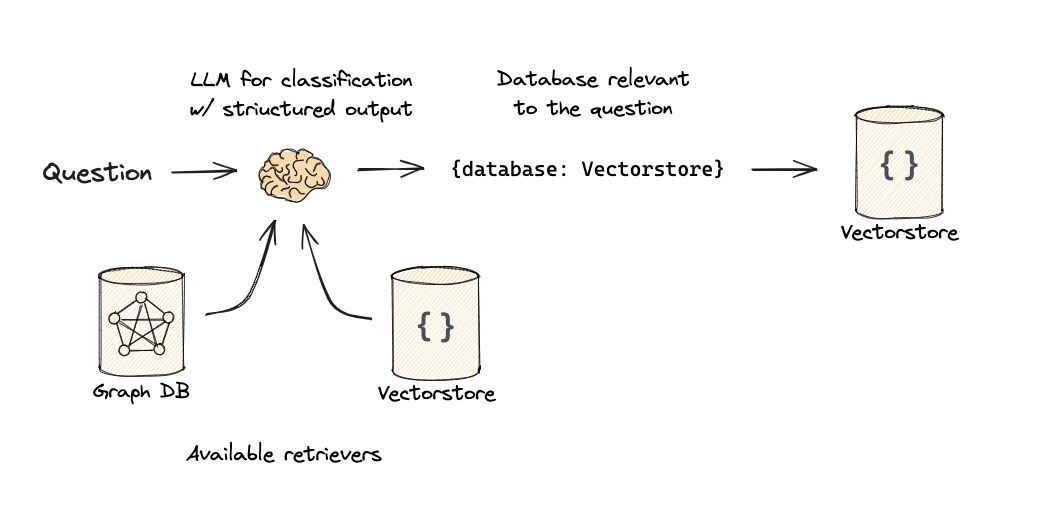

In [6]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

# LLM with function call 
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router 
router = prompt | structured_llm

In this case we used function calling to produce structured output. 

For many applications, such as chatbots, models need to respond to users directly in natural language. However, there are scenarios where we need models to output in a structured format. 

Here's how it works:

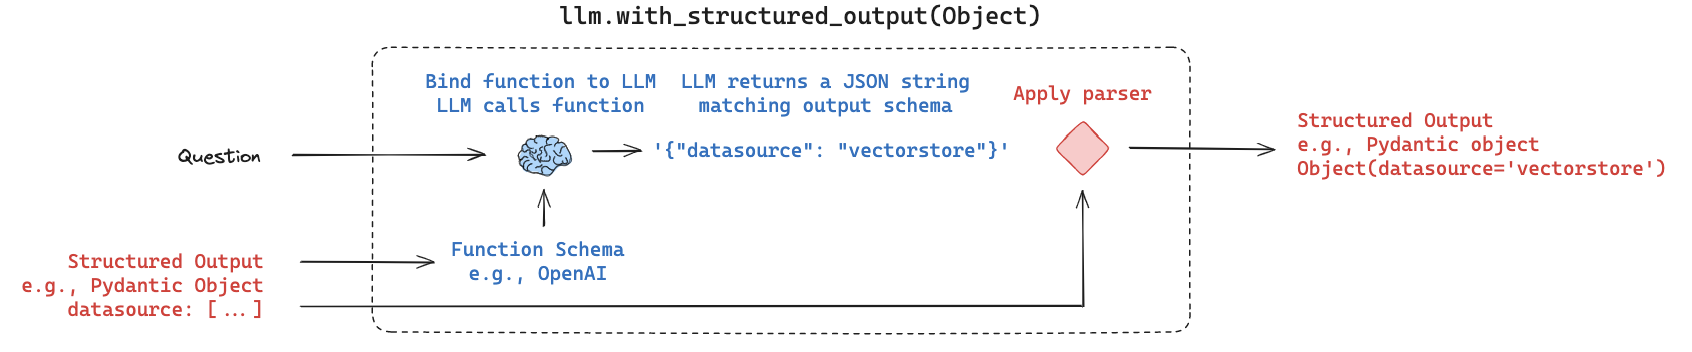

In [7]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

In [8]:
result

RouteQuery(datasource='python_docs')

In [9]:
result.datasource

'python_docs'

Once we have this, it is trivial to define a branch that uses `result.datasource`

In [10]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [11]:
full_chain.invoke({"question": question})

'chain for python_docs'

## Query Construction

With typical retrieval augmented generation (RAG), a user query is converted into a vector representation. This vector is then compared to vector representations of the source documents to find the most similar ones. This works fairly well for unstructured data, but what about structured data?

Most data in the world has some structure. Much of this data lives in relational (e.g., SQL) or graph databases. And even unstructured data often associated structured metadata (e.g., things like the author, genre, data published, etc).

For example, consider the query `what are movies about aliens in the year 1980`. There is a portion (`aliens`) that we may want to look up semantically, but also a component (`"year == 1980"`) that we want to look up in an exact way.

Definition:

`Query construction is taking a natural language query and converting it into the query language of the database you are interacting with.`

### self-querying retriever

A self-querying retriever is one that, as the name suggests, has the ability to query itself. Specifically, given any natural language query, the retriever uses a query-constructing LLM chain to write a structured query and then applies that structured query to its underlying vector store. This allows the retriever to not only use the user-input query for semantic similarity comparison with the contents of stored documents but to also extract filters from the user query on the metadata of stored documents and to execute those filters.

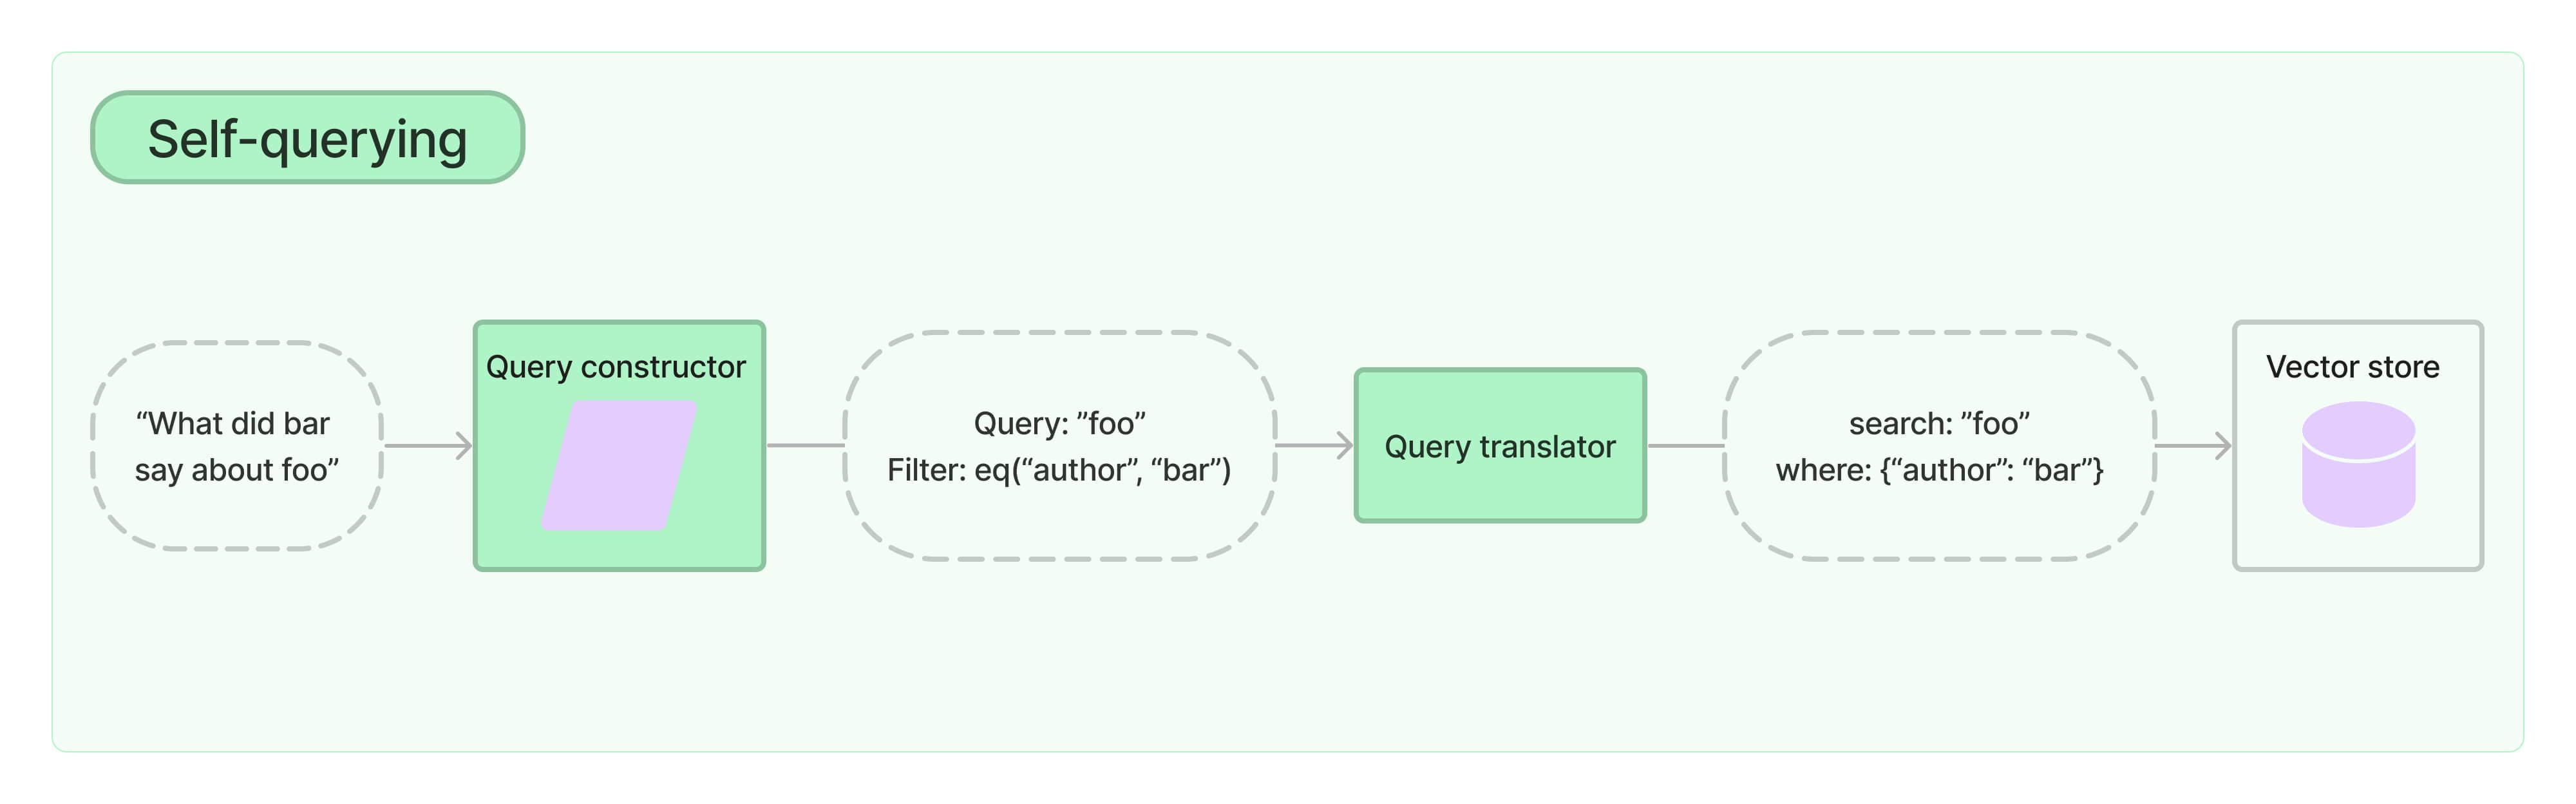

For demonstration purposes we'll use a `Chroma` vector store. We've created a small demo set of documents that contain summaries of movies.

In [11]:
from langchain_chroma import Chroma
from langchain_core.documents import Document

docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2, "genre": "science fiction"},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6, "genre": "science fiction"},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3, "genre": "drama"},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="Three men walk into the Zone, three men walk out of the Zone",
        metadata={
            "year": 1979,
            "director": "Andrei Tarkovsky",
            "genre": "thriller",
            "rating": 9.9,
        },
    ),
]
vectorstore = Chroma.from_documents(docs, embeddings)


Now we can instantiate our retriever. To do this we'll need to provide some information upfront about the metadata fields that our documents support and a short description of the document contents.

In [12]:
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]

document_content_description = "Brief summary of a movie"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)

**Testing it out**

And now we can actually try using our retriever!

In [7]:
# This example only specifies a filter
retriever.invoke("I want to watch a movie rated higher than 8.5")

[Document(id='f195be1c-5d87-4355-9387-cbb19438371b', metadata={'director': 'Satoshi Kon', 'rating': 8.6, 'genre': '', 'year': 2006}, page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea'),
 Document(id='9f9ad4d5-6129-402c-bbec-e56015cfdee3', metadata={'rating': 9.9, 'year': 1979, 'director': 'Andrei Tarkovsky', 'genre': 'thriller'}, page_content='Three men walk into the Zone, three men walk out of the Zone')]

In [8]:
# This example specifies a query and a filter
retriever.invoke("Has Greta Gerwig directed any movies about women")

[Document(id='b388845f-14bc-483c-a480-9c1f3d910dd7', metadata={'director': 'Greta Gerwig', 'genre': 'drama', 'year': 2019, 'rating': 8.3}, page_content='A bunch of normal-sized women are supremely wholesome and some men pine after them')]

In [13]:
# This example specifies a composite filter
retriever.invoke("What's a highly rated (above 8.5) science fiction film?")

[Document(id='f4ce19d3-9c2e-482f-b9f1-2be2e0736b20', metadata={'director': 'Satoshi Kon', 'year': 2006, 'rating': 8.6, 'genre': 'science fiction'}, page_content='A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea')]

In [10]:
# This example specifies a query and composite filter
retriever.invoke(
    "What's a movie after 1990 but before 2005 that's all about toys, and preferably is animated"
)

[Document(id='7434fadc-0a65-4d11-ae7c-ff7598bd87b6', metadata={'year': 1995, 'genre': 'animated'}, page_content='Toys come alive and have a blast doing so')]

### Constructing from scratch LCEL

To see what's going on under the hood, and to have more custom control, we can reconstruct our retriever from scratch.

First, we need to create a query-construction chain. This chain will take a user query and generated a StructuredQuery object which captures the filters specified by the user. We provide some helper functions for creating a prompt and output parser. These have a number of tunable params that we'll ignore here for simplicity.

In [17]:
from langchain.chains.query_constructor.base import (
    StructuredQueryOutputParser,
    get_query_constructor_prompt,
)

prompt = get_query_constructor_prompt(
    document_content_description,
    metadata_field_info,
)
output_parser = StructuredQueryOutputParser.from_components()
query_constructor = prompt | llm | output_parser

In [18]:
print(prompt.format(query="dummy question"))

Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte | contain | like | in | nin): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or | not

In [20]:
structure_query = query_constructor.invoke(
    {
        "query": "What are some sci-fi movies from the 90's directed by Luc Besson about taxi drivers"
    }
)

In [24]:
structure_query

StructuredQuery(query='taxi driver', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='genre', value='science fiction'), Comparison(comparator=<Comparator.GTE: 'gte'>, attribute='year', value=1990), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='director', value='Luc Besson')]), limit=None)

In [23]:
structure_query.filter

Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='genre', value='science fiction'), Comparison(comparator=<Comparator.GTE: 'gte'>, attribute='year', value=1990), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='director', value='Luc Besson')])

The query constructor is the key element of the self-query retriever. To make a great retrieval system you'll need to make sure your query constructor works well. Often this requires adjusting the prompt, the examples in the prompt, the attribute descriptions, etc.

The next key element is the structured query translator. This is the object responsible for translating the generic `StructuredQuery` object into a metadata filter in the syntax of the vector store you're using.

In [25]:
from langchain_community.query_constructors.chroma import ChromaTranslator

retriever = SelfQueryRetriever(
    query_constructor=query_constructor,
    vectorstore=vectorstore,
    structured_query_translator=ChromaTranslator(),
)

In [26]:
retriever.invoke(
    "What's a movie after 1990 but before 2005 that's all about toys, and preferably is animated"
)

[Document(id='7434fadc-0a65-4d11-ae7c-ff7598bd87b6', metadata={'genre': 'animated', 'year': 1995}, page_content='Toys come alive and have a blast doing so'),
 Document(id='fed27efc-3457-456c-84e9-6db619394e46', metadata={'genre': 'animated', 'year': 1995}, page_content='Toys come alive and have a blast doing so')]